In [7]:
import skimage.io as skio
import matplotlib.pyplot as plt
import numpy as np
import scipy

# JPEG Algo

Image shape: (4000, 6016, 3)
Image data type: uint8
Theoretical uncompressed image size: 68.85 MB


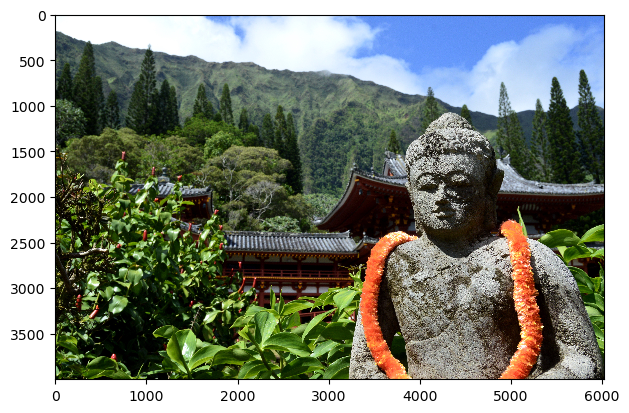

In [8]:
img = skio.imread("monk.jpg")
skio.imshow(img)

print(f'Image shape: {img.shape}')
print(f'Image data type: {img.dtype}')
print(f'Theoretical uncompressed image size: {np.round(np.prod(np.asarray(img.shape)) / (1024 ** 2),2)} MB')

In [164]:
# given an image, return image in YCbCr color space
# instead of red, green, blue channels, one brightness channel and two channels indicating deviation in blue and red respectively
# conversion taken from [wikipedia](https://en.wikipedia.org/wiki/YCbCr)
# according to ITU-R BT.709 convension
def rgb_to_YCbCr(img):
    img = img / 255
    # ITU-R BT.709 RGB to YCbCr conversion matrix
    conv_matrix = np.matrix(
    [[65.481, 128.553, 24.966], 
     [-37.797, -74.203, 112.0], 
     [112.0, -93.786, -18.214]])
    
    # reshape to do matrix multiplication across color channels easier
    img_reshape = np.reshape(img, (img.shape[0] * img.shape[1], img.shape[2]))

    # do matrix multiplication to switch color spaces
    converted_reshaped = img_reshape * np.transpose(conv_matrix)

    # go back to original shape
    converted = np.reshape(np.asarray(converted_reshaped), img.shape)

    converted[..., 0] += 16
    converted[..., 1] += 128
    converted[..., 2] += 128

    return converted

In [77]:
def YCbCr_to_rgb(img):
    inv_matrix = np.matrix(
    [[65.481, 128.553, 24.966], 
     [-37.797, -74.203, 112.0], 
     [112.0, -93.786, -18.214]])
    
    conv_matrix = np.linalg.inv(inv_matrix)

    img = img.copy() 
    
    img[..., 0] -= 16
    img[..., 1] -= 128
    img[..., 2] -= 128
    
    # reshape to do matrix multiplication across color channels easier
    img_reshape = np.reshape(img, (img.shape[0] * img.shape[1], img.shape[2]))

    # do matrix multiplication to switch color spaces
    before_rounding = img_reshape * np.transpose(conv_matrix)

    range = before_rounding.max() - before_rounding.min()
    before_rounding -= before_rounding.min()
    before_rounding /= range
    
    # go back to original shape
    converted = np.reshape(np.asarray(before_rounding), img.shape)
    #converted[:, :, 1] -= 0.3

    return (converted * 255).astype(np.uint8)
    

In [11]:
# returns a tuple of arrays: first is brightness, second and third are the downscaled colors 
# could be in some sort of object later to store all information
# 4:2:0  - this one 
# 4:2:2 
def downscale_colors(img):
    Y = img[:, :, 0]
    Cb = img[::2, ::2, 1]
    Cr = img[::2, ::2, 2]

    return (Y, Cb, Cr)

In [12]:
# there are definitely some random color artifacts

def reconstruct_downscaled(img_tuple):
    Y = img_tuple[0]
    # fill out 2x2 squares with downsampled value
    Cb = np.repeat(np.repeat(img_tuple[1], 2, axis=1), 2, axis=0)
    Cr = np.repeat(np.repeat(img_tuple[2], 2, axis=1), 2, axis=0)

    wrong_order = [Y, Cb, Cr]

    img = np.transpose(wrong_order, axes=(1,2,0))

    return img

In [165]:
from skimage.util import view_as_blocks

def form_blocks(img_tuple, block_size = 8):

    blocked_by_color = []
    for img in img_tuple:
        blocked_by_color.append(view_as_blocks(img, (block_size, block_size)))

    print(blocked_by_color[1].shape)
    return blocked_by_color

In [146]:
def reconstruct_blocks(blocked_img, block_size = 8):

    print(blocked_img[0].shape)
    print(blocked_img[1].shape)
    Y_shape = (blocked_img[0].shape[0] * block_size, blocked_img[0].shape[1] * block_size)
    C_shape = (Y_shape[0] // 2, Y_shape[1] // 2)

    Y_wrong_order = np.transpose(blocked_img[0],axes=(0,2,1,3)) # i have no clue why this works but my intuition told me to do it
    Cb_wrong_order = np.transpose(blocked_img[1],axes=(0,2,1,3))
    Cr_wrong_order = np.transpose(blocked_img[2],axes=(0,2,1,3))


    Y = Y_wrong_order.reshape(Y_shape)
    Cb = Cb_wrong_order.reshape(C_shape)
    Cr = Cr_wrong_order.reshape(C_shape)

    return (Y, Cb, Cr)

In [171]:
def calculate_blocked_dct(blocked_img):
    blocked_img[0] -= 128 # want the whole thing centered at 0
    blocked_img[1] -= 128 
    blocked_img[2] -= 128 

    print(f'datatype of calculate_blocked_dct: {blocked_img[0].dtype}')

    dct_array = []
    for img in blocked_img:
        dct_array.append(scipy.fftpack.dctn(img, axes=(-2,-1)))

    print(blocked_img[1].shape)
    return dct_array

In [167]:
def inverse_block_dct(dct_img):
    blocked_img = []
    for img in dct_img:
        blocked_img.append(scipy.fftpack.idctn(img, axes=(-2,-1)))
    
    blocked_img[0] += 128 # want the whole thing centered at 0
    blocked_img[1] += 128 # want the whole thing centered at 0
    blocked_img[2] += 128 # want the whole thing centered at 0

    return blocked_img

In [177]:
def quantize(img_tuple, quality = 0.5):
    # as specified in JPEG standard
    default = np.array([
    [6, 4, 4, 6, 10, 16, 20, 24],
    [5, 5, 6, 8, 10, 23, 24, 22],
    [6, 5, 6, 10, 16, 23, 28, 22],
    [6, 7, 9, 12, 20, 35, 32, 25],
    [7, 9, 15, 22, 27, 44, 41, 31],
    [10, 14, 22, 26, 32, 42, 45, 37],
    [20, 26, 31, 35, 41, 48, 48, 40],
    [29, 37, 38, 39, 45, 40, 41, 40]
    ])

    q = 1 / default

    print(img_tuple[0][150,150, :, :])
    
    quantized_tuple = []
    for img in img_tuple:
        
        result = img * q[np.newaxis, np.newaxis, :, :]
        result = result.astype(np.int8) 
        
        quantized_tuple.append(result)

    print(quantized_tuple[0][150,150, :, :])
    print(img_tuple[1].shape)


    return result

In [186]:
def dequantize(img_tuple, quality = 0.5):
    # ill do this tomorrow
    default = np.array([
    [6, 4, 4, 6, 10, 16, 20, 24],
    [5, 5, 6, 8, 10, 23, 24, 22],
    [6, 5, 6, 10, 16, 23, 28, 22],
    [6, 7, 9, 12, 20, 35, 32, 25],
    [7, 9, 15, 22, 27, 44, 41, 31],
    [10, 14, 22, 26, 32, 42, 45, 37],
    [20, 26, 31, 35, 41, 48, 48, 40],
    [29, 37, 38, 39, 45, 40, 41, 40]
    ])
    q = default
    dequantized_tuple = []
    for img in img_tuple:
        
        result = img * q[np.newaxis, :, :]
        
        dequantized_tuple.append(result)

    print(dequantized_tuple[0][150,150, :, :])
    print(dequantized_tuple[1].shape)
    
    return dequantized_tuple

In [161]:
def jpeg_compress(img):
    img_ybr = rgb_to_YCbCr(img)
    downscaled = downscale_colors(img_ybr)
    blocked = form_blocks(downscaled)
    dct = calculate_blocked_dct(blocked)
    quantized = quantize(dct)

    return quantized

In [162]:
def jpeg_decompress(img):
    reshaped = img
    dequantized = dequantize(reshaped)
    # dequantized = img
    idct = inverse_block_dct(dequantized)
    unblocked = reconstruct_blocks(idct)
    reconstructed_down = reconstruct_downscaled(unblocked)
    reconstructed_image = YCbCr_to_rgb(reconstructed_down)
    
    return reconstructed_image

In [187]:
compressed = jpeg_compress(img)
decompressed = jpeg_decompress(compressed)

fig, axs = plt.subplots(1, 2)
fig.set_figheight(12)
fig.set_figwidth(10)

axs[0].imshow(img)
axs[0].set_title("Original")

axs[1].imshow(decompressed)
axs[1].set_title("Reconstruction")
    

(250, 376, 8, 8)
datatype of calculate_blocked_dct: float64
(250, 376, 8, 8)
[[-2.49856718e+04  5.78022001e+01 -6.54216809e+01  6.38985730e+01
  -1.17326485e+00  5.61679054e+00 -4.32374220e+00  2.94257736e+00]
 [ 1.22348311e+00  5.82611996e+01  4.85880560e+01 -5.74802489e+01
   9.11756215e+00 -7.75750172e+01 -4.63285022e+00  3.88041567e+00]
 [-3.97556630e+01 -3.73329943e+00  3.90246495e+01 -1.21785852e+00
  -1.73109003e+00 -1.22537785e+00  6.02698614e+00  4.50764756e+00]
 [ 6.55177440e+01 -3.35330257e+01  1.64033723e+00  7.25839891e+00
  -3.03529797e+00  3.60568907e+00 -2.85743400e+00 -7.71197393e-01]
 [ 1.22670548e+00 -7.12406322e+01  4.18081642e+00 -5.92602108e+00
  -4.37828235e+00 -2.68782722e+00 -7.54165017e+00  3.41218405e-01]
 [-1.20800387e+01  6.68449794e-01  7.24360705e+00 -3.96254097e+00
  -6.42427956e+00  2.05843751e+00  1.68900602e+00  3.62897142e+00]
 [ 4.30700597e+00 -9.51734562e+00 -1.04971974e+00  2.28424140e+00
   3.45559511e+00  1.86490076e-02 -4.63392007e+00  1.415169

IndexError: too many indices for array: array is 3-dimensional, but 4 were indexed

In [ ]:
from skimage.color import rgb2ycbcr, ycbcr2rgb
skimage_ybr = rgb2ycbcr(img)
skimage_downscaled = downscale_colors(skimage_ybr)
skimage_rescaled = reconstruct_downscaled(skimage_downscaled)
skimage_reconstructed = ycbcr2rgb(skimage_rescaled)

skio.imshow(skimage_reconstructed[3550:3600,850:925,:], interpolation = "none")

In [ ]:
sample = reconstructed_image[3550:3600,850:925,:]
single_color = reconstructed_down[3550:3600,850:925, 0]

fig, axs = plt.subplots(1, 2)
fig.set_figheight(12)
fig.set_figwidth(10)

axs[0].imshow(sample)
axs[0].set_title("Original")

axs[1].imshow(single_color, cmap = "gray")
axs[1].set_title("Reconstruction")
    

In [ ]:
sample = reconstructed_image[100:200, 2500:2600, :]
skio.imshow(sample)

In [ ]:
sample = img[100:200, 2500:2600, :]
skio.imshow(sample)

In [ ]:
sample = reconstructed_image[1500:1600, 1750:1850, :]
skio.imshow(sample)

In [ ]:
just_downsample = downscale_colors(img)
just_downsample_reconstruction = reconstruct_downscaled(just_downsample)
skio.imshow(just_downsample_reconstruction)